<a href="https://colab.research.google.com/github/ARMINPAN/Advance-Neuroscience-Final-Project/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# advance neuro project

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import seaborn as sns
sns.set_theme()

In [3]:
# select the device to run the code on
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

In [4]:
def ReLU(x):
    zeros_mat = torch.zeros(x.shape, device=dev)
    output = torch.fmax(x, zeros_mat)
    return output

In [5]:
def ReLU_deriv(x):
    non_negs = torch.where(x >= 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1
    return output

In [6]:
def angleCal(A, B):
    num = torch.trace(torch.matmul(torch.conj(A.T), B))
    norm_A = math.sqrt(torch.trace(torch.matmul(A,torch.conj(A.T))))
    norm_B = math.sqrt(torch.trace(torch.matmul(B,torch.conj(B.T))))
    denum = norm_A*norm_B
    angle = torch.arccos(num/denum)*180/math.pi
    return angle

In [6]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles1 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)
    
    # input layer values - # move on gpu
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


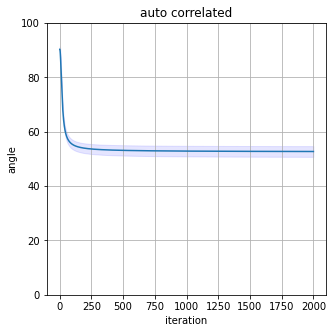

In [7]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles2 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.clone(input_layer) # cross correlated with inputs of network
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
    
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = torch.clone(error_delta2)
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.clone(input_layer)
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


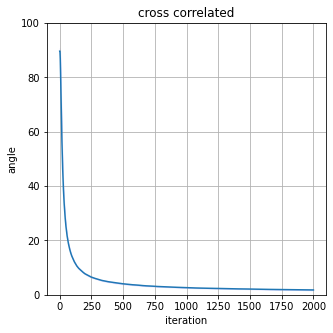

In [ ]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles3 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta1 = torch.matmul(error_delta2, backward_weight_1)

    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) 
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


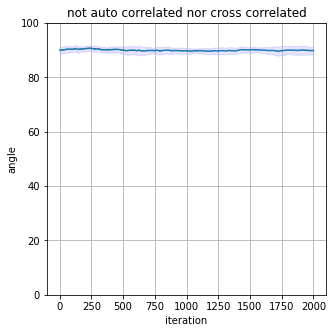

In [ ]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - forth condition - auto correlated & cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles4 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = input_layer # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    # delta 2 doesn't change

    for j in range (number_of_iterations):
        angles4[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


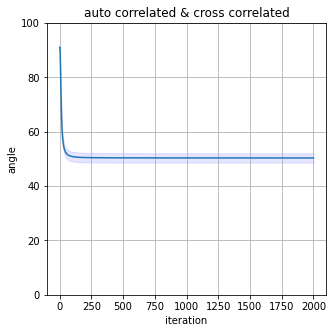

In [ ]:
# plot the result of auto correlated & cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('auto correlated & cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


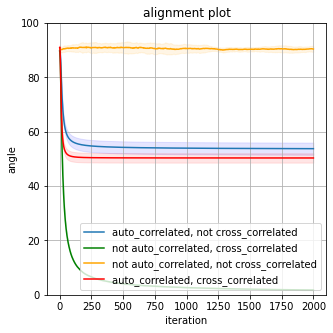

In [ ]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='orange', alpha=.1);

# condition 4
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0),color='red')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence4 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='red', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated',\
          'auto_correlated, cross_correlated'],loc='lower right')

In [ ]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [7]:
def n_hot_coder(x,n,hot_labels,output_neuron_num):
    labels = x.cpu().numpy()
    category_num = 10
    if(category_num*n > output_neuron_num):
        print('nhot encoding can`t be done since the condition`s not met')
        return False
    
    output = torch.zeros((len(x),output_neuron_num), device=dev)
    
    output[np.where(labels == 0),:] = hot_labels[0,:]
    output[np.where(labels == 1),:] = hot_labels[1,:]
    output[np.where(labels == 2),:] = hot_labels[2,:]
    output[np.where(labels == 3),:] = hot_labels[3,:]
    output[np.where(labels == 4),:] = hot_labels[4,:]
    output[np.where(labels == 5),:] = hot_labels[5,:]
    output[np.where(labels == 6),:] = hot_labels[6,:]
    output[np.where(labels == 7),:] = hot_labels[7,:]
    output[np.where(labels == 8),:] = hot_labels[8,:]
    output[np.where(labels == 9),:] = hot_labels[9,:]

    return output

In [8]:
def loss_function(output_layer,labels):
    difference = labels-output_layer
    output = 0.5*(torch.sum(difference**2))
    return output

In [9]:
def tanh_Relu_deriv(x):
    non_negs = torch.where(x > 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1-torch.tanh(x[non_negs])**2
    return output

In [10]:
def binarize_output(output,n,categories_nhot):
  
    binarized = torch.zeros((output.shape[0],output.shape[1]), device=dev)
    current_data_scores = torch.matmul(output,categories_nhot.T)
    _, closest_label = torch.max(current_data_scores,dim=1)
    binarized = categories_nhot[closest_label,:]
    
    return binarized

In [11]:
def accuracy_cal(output,label):
    acc = 0
    
    compare = output.shape[1]*torch.ones((output.shape[0]), device=dev)
    acc = torch.sum(torch.eq(torch.sum(torch.eq(output,label),dim=1),compare))
  
    acc = acc/len(output)*100 # in percentage
    return acc

In [12]:
def alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime,output_layer_size):

    alignment_terms = [];
    
    
    # cal alignment terms
    for i in range(1,iter_needed): # iteration
      if(i == 65 or i == 1259):
          print(i)
          o = 0
          torch.cuda.empty_cache()
          alignment_terms_k = torch.zeros((i,layer_num,output_layer_size,output_layer_size), device=dev)
          while (o < i):
              # l1
              alignment_terms_k[o,0,:,:] = (LR**2)*torch.chain_matmul(B1.T,delta2_inTime[i-o-1,:,:].T,\
                                                                      input_layer[np.mod(i-o-1,batch_num),:,:],input_layer[np.mod(i,batch_num),:,:].T,\
                                                                      delta2_inTime[i,:,:])
              # l2
              alignment_terms_k[o,1,:,:] = (LR**2)*torch.chain_matmul(B2.T,delta3_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer1_inTime[i-o-1,:,:],hidden_layer1_inTime[i,:,:].T,\
                                                                      delta3_inTime[i,:,:])
              # l3
              alignment_terms_k[o,2,:,:] = (LR**2)*torch.chain_matmul(B3.T,delta4_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer2_inTime[i-o-1,:,:],hidden_layer2_inTime[i,:,:].T,\
                                                                      delta4_inTime[i,:,:])
              # l4
              alignment_terms_k[o,3,:,:] = (LR**2)*torch.chain_matmul(B4.T,delta5_inTime[i-o-1,:,:].T,\
                                                                hidden_layer3_inTime[i-o-1,:,:],hidden_layer3_inTime[i,:,:].T,\
                                                                delta5_inTime[i,:,:])
              
              o += 1
          
          alignment_terms.append(alignment_terms_k)
        
    return alignment_terms

In [13]:
def create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                   hidden_layer3_size,hidden_layer4_size,output_layer_size):

  # forward weights
  w0 = torch.normal(mu,sigma,size=(input_layer_size,hidden_layer1_size), device=dev)
  w1 = torch.normal(mu,sigma,size=(hidden_layer1_size,hidden_layer2_size), device=dev)
  w2 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer3_size), device=dev)
  w3 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer4_size), device=dev)
  w4 = torch.normal(mu,sigma,size=(hidden_layer4_size,output_layer_size), device=dev)

  # backward weights
  B4 = torch.normal(mu,sigma,size=(output_layer_size,hidden_layer4_size), device=dev)
  B3 = torch.normal(mu,sigma,size=(hidden_layer4_size,hidden_layer3_size), device=dev)
  B2 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer2_size), device=dev)
  B1 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer1_size), device=dev)

  # bias vectors
  b1 =  torch.normal(mu,sigma,size=(1,hidden_layer1_size), device=dev)
  b2 =  torch.normal(mu,sigma,size=(1,hidden_layer2_size), device=dev)
  b3 =  torch.normal(mu,sigma,size=(1,hidden_layer3_size), device=dev)
  b4 =  torch.normal(mu,sigma,size=(1,hidden_layer4_size), device=dev)
  b5 =  torch.normal(mu,sigma,size=(1,output_layer_size), device=dev)

  print('network parameters created!')

  return w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5


In [14]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert images to pytorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
data loaded!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [15]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [16]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train = y_train.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [20]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [21]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot = n_hot_coder(y_train,n,categories_nhot,output_neuron_num)
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')
print(y_train_nhot.shape, y_test_nhot.shape)


n hot coding done!
torch.Size([60000, 50]) torch.Size([10000, 50])


In [22]:
# create the network weights and biases from N(mu,sigma)
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50

w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                   hidden_layer3_size,hidden_layer4_size,output_layer_size)



network parameters created!


In [23]:
import pandas as pd
import gc

gc.collect()
# run the network - calculate alignment terms and angles between B and W simultaneously

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 30


accuracy_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)

# angle between B & W
alignment = torch.zeros((run_num,4,batch_num,epoch_num), device=dev)


# alignment between alignment terms & B
alignment_terms = []
angles_alignment_terms = np.zeros((run_num,2,65,layer_num))


for k in range(run_num):
  print('run ', k, ' ...')

  # create network parameters
  w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
  create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                    hidden_layer3_size,hidden_layer4_size,output_layer_size)
  
  
  # layer and delta values in iterations for calculating alignment terms
  iter_needed = 1260
  hidden_layer1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)
  hidden_layer2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
  hidden_layer3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
  hidden_layer4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
  delta5_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
  delta4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
  delta3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
  delta2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)


  for j in range(epoch_num):

      for i in range(batch_num):
          # forward
          z1 = torch.matmul(input_layer[i,:,:],w0) + b1
          hidden_layer1 = torch.tanh(ReLU(z1))
          z2 = torch.matmul(hidden_layer1,w1) + b2
          hidden_layer2 = torch.tanh(ReLU(z2))
          z3 = torch.matmul(hidden_layer2,w2) + b3
          hidden_layer3 = torch.tanh(ReLU(z3))
          z4 = torch.matmul(hidden_layer3,w3) + b4
          hidden_layer4 = torch.tanh(ReLU(z4))
          z5 = torch.matmul(hidden_layer4,w4) + b5
          output_layer = torch.tanh(ReLU(z5))
          
          # backward the error
          E = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer
          delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
          delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
          delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
          delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
          delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
          
          # save values in time for calculating alignment terms - just up to iteration 1260
          if(j*batch_num+i < iter_needed):
              hidden_layer1_inTime[j*batch_num+i,:,:] = hidden_layer1
              hidden_layer2_inTime[j*batch_num+i,:,:] = hidden_layer2
              hidden_layer3_inTime[j*batch_num+i,:,:] = hidden_layer3
              hidden_layer4_inTime[j*batch_num+i,:,:] = hidden_layer4
              delta5_inTime[j*batch_num+i,:,:] = delta5
              delta4_inTime[j*batch_num+i,:,:] = delta4
              delta3_inTime[j*batch_num+i,:,:] = delta3
              delta2_inTime[j*batch_num+i,:,:] = delta2
              
          
          # update forward weights 
          w4 += LR*torch.matmul(hidden_layer4.T,delta5)
          w3 += LR*torch.matmul(hidden_layer3.T,delta4)
          w2 += LR*torch.matmul(hidden_layer2.T,delta3)
          w1 += LR*torch.matmul(hidden_layer1.T,delta2)
          w0 += LR*torch.matmul(input_layer[i,:,:].T,delta1)
          
          # update biases
          J = torch.ones((1,batch_size), device=dev)
          b5 += torch.squeeze(LR*torch.matmul(J,delta5))
          b4 += torch.squeeze(LR*torch.matmul(J,delta4))
          b3 += torch.squeeze(LR*torch.matmul(J,delta3))
          b2 += torch.squeeze(LR*torch.matmul(J,delta2))
          b1 += torch.squeeze(LR*torch.matmul(J,delta1))
          
          # binarize output
          n = 5 # n hot
          output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

          # loss values
          loss_training[k,i,j] = loss_function(output_layer,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
          accuracy_training[k,i,j] = accuracy_cal(output_layer_binarized,y_train_nhot[i*batch_size:(i+1)*batch_size,:]);
          
          # cal the angle between B & W
          alignment[k,0,i,j] = angleCal(w1,B1.T)
          alignment[k,1,i,j] = angleCal(w2,B2.T) 
          alignment[k,2,i,j] = angleCal(w3,B3.T) 
          alignment[k,3,i,j] = angleCal(w4,B4.T) 

      
          
      print(torch.mean(accuracy_training[k,:,j]),torch.mean(loss_training[k,:,j]))

  # cal aligment terms
  alignment_terms.append(alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                delta2_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                hidden_layer3_inTime,hidden_layer4_inTime,output_layer_size))
  
  # cal alignment between alignment terms & B
  for kk in range(angles_alignment_terms.shape[1]):
    T_k = alignment_terms[-1][kk]
    for ii in range(angles_alignment_terms.shape[2]):
        T_o = np.squeeze(T_k[ii,:,:,:])
        angles_alignment_terms[k,kk,ii,0] = angleCal(T_o[0,:,:],B1.T)
        angles_alignment_terms[k,kk,ii,1] = angleCal(T_o[1,:,:],B2.T)
        angles_alignment_terms[k,kk,ii,2] = angleCal(T_o[2,:,:],B3.T)
        angles_alignment_terms[k,kk,ii,3] = angleCal(T_o[3,:,:],B4.T)


print('network training done!')

run  0  ...
network parameters created!
tensor(14.7183, device='cuda:0') tensor(2321.1731, device='cuda:0')
tensor(39.8600, device='cuda:0') tensor(2034.2292, device='cuda:0')
tensor(56.3150, device='cuda:0') tensor(1644.9221, device='cuda:0')
tensor(66.9467, device='cuda:0') tensor(1444.2271, device='cuda:0')
tensor(72.0750, device='cuda:0') tensor(1332.6652, device='cuda:0')
tensor(75.6517, device='cuda:0') tensor(1252.7686, device='cuda:0')
tensor(77.7667, device='cuda:0') tensor(1188.7079, device='cuda:0')
tensor(79.3350, device='cuda:0') tensor(1134.5492, device='cuda:0')
tensor(80.6333, device='cuda:0') tensor(1088.4647, device='cuda:0')
tensor(81.7400, device='cuda:0') tensor(1048.4919, device='cuda:0')
tensor(82.6050, device='cuda:0') tensor(1014.1743, device='cuda:0')
tensor(83.3783, device='cuda:0') tensor(985.3895, device='cuda:0')
tensor(84.0533, device='cuda:0') tensor(961.2699, device='cuda:0')
tensor(84.5333, device='cuda:0') tensor(941.1010, device='cuda:0')
tensor(85.0

/usr/local/lib/python3.7/dist-packages/torch/functional.py:1638: UserWarning: torch.chain_matmul is deprecated and will be removed in a future PyTorch release. Use torch.linalg.multi_dot instead, which accepts a list of two or more tensors rather than multiple parameters. (Triggered internally at  ../aten/src/ATen/native/LinearAlgebra.cpp:877.)
  return _VF.chain_matmul(matrices)  # type: ignore[attr-defined]


run  1  ...
network parameters created!
tensor(20.7633, device='cuda:0') tensor(2259.8262, device='cuda:0')
tensor(48.9633, device='cuda:0') tensor(1907.5350, device='cuda:0')
tensor(64.7150, device='cuda:0') tensor(1631.6849, device='cuda:0')
tensor(70.0300, device='cuda:0') tensor(1444.8258, device='cuda:0')
tensor(73.3167, device='cuda:0') tensor(1321.5236, device='cuda:0')
tensor(76.1983, device='cuda:0') tensor(1234.6249, device='cuda:0')
tensor(78.0417, device='cuda:0') tensor(1172.3768, device='cuda:0')
tensor(79.6600, device='cuda:0') tensor(1125.2297, device='cuda:0')
tensor(80.7650, device='cuda:0') tensor(1087.4742, device='cuda:0')
tensor(81.6200, device='cuda:0') tensor(1056.9341, device='cuda:0')
tensor(82.3733, device='cuda:0') tensor(1031.2876, device='cuda:0')
tensor(83.0733, device='cuda:0') tensor(1008.9137, device='cuda:0')
tensor(83.7800, device='cuda:0') tensor(982.1526, device='cuda:0')
tensor(84.4633, device='cuda:0') tensor(950.4358, device='cuda:0')
tensor(85.

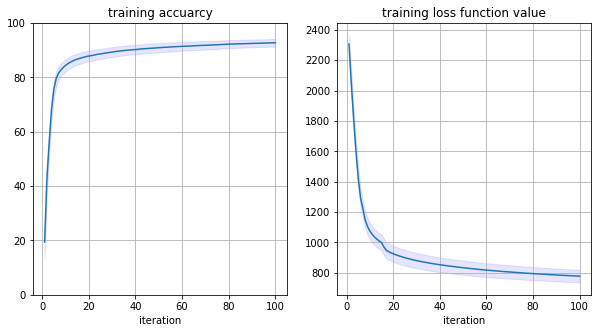

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=(0,1)))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(loss_training.cpu().numpy(),axis=(0,1)))
ax[0].fill_between(np.arange(1,epoch_num+1),\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))-np.std(accuracy_training.cpu().numpy(),axis=(0,1)),\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))+np.std(accuracy_training.cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1);
ax[1].fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))-np.std(loss_training.cpu().numpy(),axis=(0,1)),\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))+np.std(loss_training.cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1); 
ax[0].set_ylim(0,100)          
ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

In [ ]:
import pandas as pd

# accuracy on test data - dont run if running other next parts pls

batch_size = 1
batch_num = int(x_te_norm.shape[0]/batch_size)
im_size = 15*15
input_layer = x_te_norm.reshape((batch_num,batch_size,im_size))
accuracy_training = torch.zeros((batch_num), device=dev)
loss_training = torch.zeros((batch_num), device=dev)

for i in range(batch_num):
    # forward
    z1 = torch.matmul(input_layer[i,:,:],w0) + b1
    hidden_layer1 = torch.tanh(ReLU(z1))
    z2 = torch.matmul(hidden_layer1,w1) + b2
    hidden_layer2 = torch.tanh(ReLU(z2))
    z3 = torch.matmul(hidden_layer2,w2) + b3
    hidden_layer3 = torch.tanh(ReLU(z3))
    z4 = torch.matmul(hidden_layer3,w3) + b4
    hidden_layer4 = torch.tanh(ReLU(z4))
    z5 = torch.matmul(hidden_layer4,w4) + b5
    output_layer = torch.tanh(ReLU(z5))

    # binarize output
    n = 5
    output_layer_binarized = binarize_output(output_layer,n,categories_nhot)
    
    # loss val and accuracy
    loss_training[i] = loss_function(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])
    accuracy_training[i] = accuracy_cal(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:]);

print('accuracy: ',torch.mean(accuracy_training),' | loss value: ', torch.mean(loss_training))
print('done!')

accuracy:  tensor(91.7900, device='cuda:0')  | loss value:  tensor(0.4105, device='cuda:0')
done!


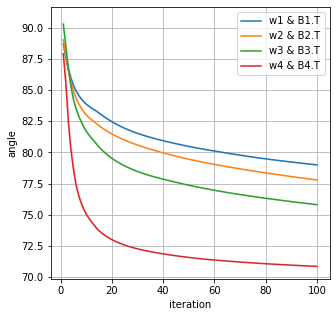

In [ ]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)))


ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)),\
                color='orange', alpha=.1);           

ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)),\
                color='green', alpha=.1);     
                
ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)),\
                color='red', alpha=.1); 


ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.legend(['w1 & B1.T','w2 & B2.T','w3 & B3.T','w4 & B4.T'],loc='best')
ax.grid(True)

(30, 2, 65, 4)


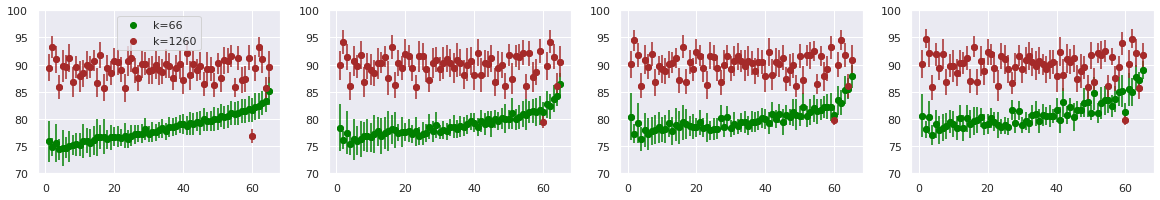

In [38]:
print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,3))


# mean
ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0),color = "green")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0),color = "green")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0),color = "green")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0),color = "green")

ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0),color = "brown")
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0),color = "brown")
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0),color = "brown")
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0),color = "brown")

# errorbars
ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,0],axis=0),fmt="o",color = "green")
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,1],axis=0), fmt="o",color = "green")
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,2],axis=0), fmt="o",color = "green")
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,0,:,3],axis=0), fmt="o",color = "green")

ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,0],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,0],axis=0), fmt="o",color = "brown")
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,1],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,1],axis=0), fmt="o",color = "brown")
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,2],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,2],axis=0), fmt="o",color = "brown")
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,:,3],axis=0), yerr=np.std(angles_alignment_terms[:,1,:,3],axis=0), fmt="o",color = "brown")

# set constant xylim
ax[0].set_ylim([1, 66])
ax[1].set_ylim([1, 66])
ax[2].set_ylim([1, 66])
ax[3].set_ylim([1, 66])

ax[0].set_ylim([70, 100])
ax[1].set_ylim([70, 100])
ax[2].set_ylim([70, 100])
ax[3].set_ylim([70, 100])



ax[0].legend(['k=66','k=1260'],loc='best')
